In [1]:
%matplotlib widget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skspatial.objects import Line, Points, Plane
from scipy.signal import argrelmin, argrelmax, argrelextrema

In [2]:
search_radius = 200
distance_between_planes = 5

In [3]:
def open_line(file_name):
    '''
    Opens one of the text files and parses the line into a skspatial object
    '''
    
    with open(file_name) as f:
        lines = f.readlines()

    point = [float(dim) for dim in lines[0].split()[1:]]
    line = [float(dim) for dim in lines[1].split()[1:]]
    
    return Line(point, line)

In [4]:
chargedAAs_arr = pd.read_csv('./chargedAAs.csv',header=None).to_numpy()
chargedAAs = dict()
for pair in chargedAAs_arr:
    chargedAAs[pair[0]] = pair[1]
# print(chargedAAs)
# print(list(chargedAAs.keys()))

In [5]:
def charged_AA_loc(file_name):    

    with open(file_name) as pdb_structure:
        lines = pdb_structure.readlines()

    axis = open_line('./line_7DTC.txt')

    charged_AA = []
    charges = []

    for line in lines:
        line = line[:22] + ' ' + line[22:] # correct .pdb stupidity        
        line = line.split()

        if len(line) > 5:
            pass
        else:
            continue

        if line[2] == 'CA' and line[3] in list(chargedAAs.keys()):
            x = float(line[6])
            y = float(line[7])
            z = float(line[8])
            point = [x,y,z]
            if axis.distance_point(point) < search_radius:
                charged_AA.append(point)
                charges.append(chargedAAs[line[3]])


       

    return (np.array(charged_AA), charges)

In [6]:
def open_carbon_atoms(file_name):    

    with open(file_name) as pdb_structure:
        lines = pdb_structure.readlines()

    allCA_7EJ1 = list()

    for line in lines:
        line = line[:22] + ' ' + line[22:] # correct .pdb stupidity        

        if len(line.split()) > 5:
            residue_num = int(line.split()[5])
            chain = line.split()[4]
        else:
            continue

        if 'CA' in line:
            x = float(line.split()[6])
            y = float(line.split()[7])
            z = float(line.split()[8])
            data = [x,y,z]
            allCA_7EJ1.append(data)

    return np.array(allCA_7EJ1)

In [7]:

locs_charges = charged_AA_loc('../DATA/ALIGNED/SCN/6AGF.pdb')
line = open_line('./line_7DTC.txt')
# print(locs_charges)
CAs = open_carbon_atoms('../DATA/ALIGNED/SCN/6AGF.pdb')

C:\Users\Mark\AppData\Local\Temp\ipykernel_21900\35881364.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


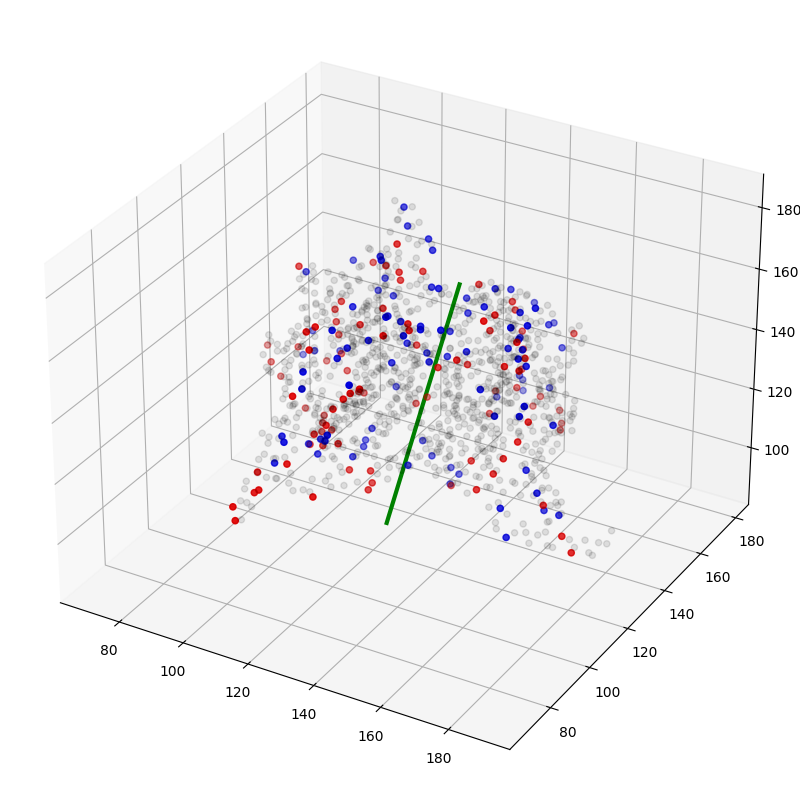

In [8]:
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)

line.plot_3d(ax, -40, 40, linewidth = 3, c = 'g')
ax.scatter(locs_charges[0][:,0], locs_charges[0][:,1], locs_charges[0][:,2], c = locs_charges[1], cmap = 'bwr', marker = 'o') # red is positive, blue is negative
ax.scatter(CAs[:,0], CAs[:,1], CAs[:,2], c='k', alpha=0.1)
# ax.scatter(line.point[0], line.point[1], line.point[2], c = 'y', marker = 'o')
ax.set_label(['x','y','z'])
plt.show()

In [9]:
dt = 1
t = list(range(-100,100,dt))
plane_points = np.array([line.point + line.vector * i for i in t])
orthogonal_planes = np.array([Plane(plane_points[i], line.vector) for i in range(plane_points.shape[0])])
line_charges = np.zeros(orthogonal_planes.shape[0])

for i in range(orthogonal_planes.shape[0] - 1):    
    for j in range(len(locs_charges[1])):
        if orthogonal_planes[i].side_point(locs_charges[0][j]) > 0 and orthogonal_planes[i + 1].side_point(locs_charges[0][j]) < 0:
            line_charges[i] = line_charges[i] + locs_charges[1][j]

# print(line_charges)

line_potential = []
for point in plane_points:
    potential = 0
    for i in range(len(locs_charges[1])):
        dx = locs_charges[0][i][0] - point[0]
        dy = locs_charges[0][i][1] - point[1]
        dz = locs_charges[0][i][2] - point[2]
        r = np.sqrt(dx**2 + dy**2 + dz**2)
        potential += locs_charges[1][i]/r
    line_potential.append(potential)

line_potential = np.array(line_potential)
# print(line_potential)



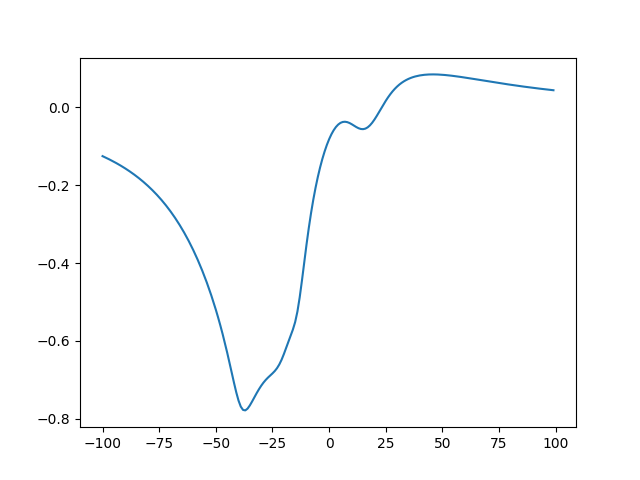

In [10]:
fig, ax = plt.subplots()
ax.plot(t, line_potential)
plt.show()

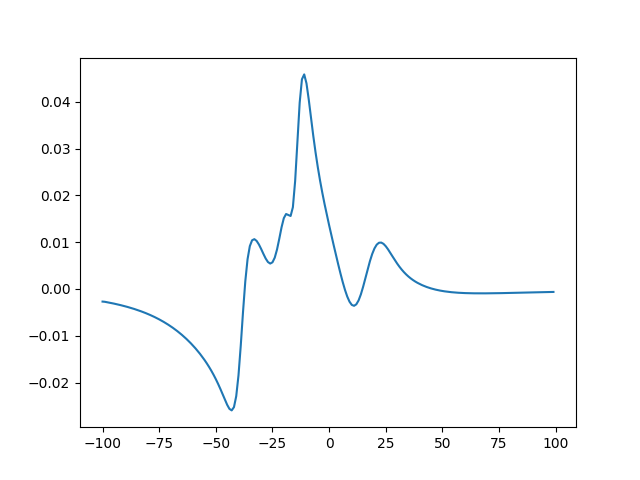

In [11]:
line_potential_diff = np.gradient(line_potential)
fig, ax = plt.subplots()
ax.plot(t, line_potential_diff)
plt.show()

In [12]:
num_min_max = len(argrelmax(line_potential)) + len(argrelmin(line_potential))
print(num_min_max)

features = [min(line_potential), max(line_potential_diff), min(line_potential_diff)]

print(list(argrelmin(line_potential, order=2))[0])

2
[ 63 115]


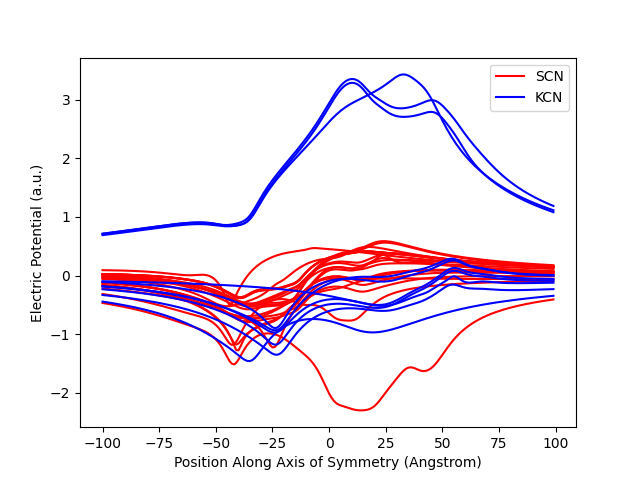

In [16]:
df = pd.read_csv('./line_potentials.csv')
pots=[[float(i) for i in df['Line_potential'].loc[j].strip('[]').split()] for j in range(len(df))]

fig, ax = plt.subplots()
a = 0
b=0
for i in range(len(pots)):
    if df['Channel'].loc[i] == 'SCN':
        if a <1:
            ax.plot(t,pots[i], c='r', label='SCN')
            a+=1
        else:
            ax.plot(t,pots[i], c='r')
    else:
        if b<1:
            ax.plot(t,pots[i], c='b', label='KCN')
            b +=1
        else:
            ax.plot(t,pots[i], c='b')
ax.legend()
ax.set_ylabel('Electric Potential (a.u.)')
ax.set_xlabel('Position Along Axis of Symmetry (Angstrom)')
plt.show()